In [1]:
import sys
sys.path.append('..')
import config

from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os               # for reading directories
import seaborn as sns   # for plotting heatmaps

# Connect to MongoDB
client = MongoClient(config.__host, config.__port)

### Init

In [2]:
RESULTS_DIR = "./results_stanford"
__db_name = "scipub_stanford"
main_collection_name = "papers"
initial_years = [1992, 1994]
influence_years = [1995, 2003]
total_correlations = pd.DataFrame()

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(RESULTS_DIR)
print('Is connection estabilished? {0}'.format(client[__db_name][main_collection_name].count_documents({}) != 0))

Is connection estabilished? True


In [41]:
####################### Select parameters ###########################

#get DataFrame of fit values for each time window
def fit_overview(topic, local_collection):
    pipeline = [
        {'$match': {'overlap': {'$exists': True}}}, 
        {'$project': {'_id':0, topic:1, 'experiment': { '$concat': [ {'$substr': ["$time_window_size", 0, -1 ]}, " - ", {'$substr': ["$overlap", 0, -1 ]}] }, 'overlap': 1, 'time_window_size': 1}} 
    ]
    
    for item in["number_of_new_authors", "number_of_authors", "number_of_papers"]:
        for index, item_2 in enumerate(["a", "b"]):
            pipeline[-1]['$project'][item+"_"+item_2] = {'$arrayElemAt': ['$fit.'+item+'.params', index]}
    
    return pd.DataFrame(list(local_collection.aggregate(pipeline, allowDiskUse=True)))

#get correlations among time windows
def TW_correlations(main_topic, local_collection):
    fit_df = fit_overview(main_topic, local_collection)
    tmp = fit_df[[main_topic, "experiment", "number_of_new_authors_a"]].pivot(index=main_topic, columns="experiment", values="number_of_new_authors_a").dropna(thresh=1)
    print("### Considering the", len(tmp), "items having at least one parameter")
    correlations = []
    for item_1 in tmp.columns:
        list_of_correlations = []
        number_of_items = []
        for item_2 in tmp.columns:
            if item_1 != item_2:
                tmp_loc = tmp[[item_1, item_2]].dropna()
                number_of_items += [len(tmp_loc)]
                list_of_correlations += [tmp_loc[item_1].corr(tmp_loc[item_2], method='spearman')]
        correlations += [{"experiment": item_1, "mean": np.mean(list_of_correlations), "std": np.std(list_of_correlations), "time_window_size": int(item_1[0]), "overlap": int(item_1[-1])}]
    return correlations

#plot heatmap
def plot_heatmap(df, use_index=False, type=None, highlight_diagonal=True, show_values=False, fmt = '.0f', cbar=True, columns=None, partitions=[], figsize=(8,8), filename=""):
    fig = plt.figure(figsize = figsize)
    
    mask = np.zeros_like(np.array(df))
    if type == "diag":
        mask[np.diag_indices_from(mask)] = True
    elif type == "upper":
        mask[np.triu_indices_from(mask)] = True
        mask[np.diag_indices_from(mask)] = False
    elif type == "lower":
        mask[np.tril_indices_from(mask)] = True
    
    to_plot = df.copy()
    if use_index:
        ax = sns.heatmap(to_plot, square=1, linewidth=1., mask=mask, annot=show_values, fmt = fmt, cmap="Greens", cbar=cbar)#, xticklabels=ticklabels, yticklabels=ticklabels)
    else:
        ax = sns.heatmap(to_plot[to_plot.columns[1:]], square=1, linewidth=1., vmin=0, mask=mask, annot=show_values, fmt = fmt, cmap="Greens")#, xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    if highlight_diagonal:
        number_of_items = len(df)
        for index in range(number_of_items):
            ax.add_patch(Rectangle((number_of_items-index-1, index), 1, 1, fill=False, edgecolor='lightgrey', lw=2))
    #highlight partitions
    if partitions:
        for partition in partitions:
            ax.add_patch(Rectangle((partition[0], len(to_plot)-partition[1]-1), (partition[1] - partition[0] + 1), (partition[1] - partition[0] + 1), fill=False, edgecolor='black', lw=2))
    
    ax.set(title='', xlabel=r'Length of Overlap ($\gamma$)', ylabel=r'Length of Time Window ($\delta$)')
    
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return

####################### Get scores ###########################

field_of_citations = 'cited_by'#'acm_cited_by'

def get_authors_score(param_name, param_index, time_window_size, overlap, topic, N, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1, 'g_index': 1, 'g_index_local': 1, 'i'+str(N)+'_index': 1, 'i'+str(N)+'_index_local': 1, 'm_index': 1, 'm_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#papers written by a list of authors, with the year of first (or last) publication
def list_of_authors(list_of_papers=None, range_of_years=None, local_collection=main_collection_name):
    
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$sort': {'authors': 1, 'year': 1}},
            {'$group': {'_id' : '$authors', 'year_first': {'$first': '$year'}, 'year_last': {'$last': '$year'} }},
            {'$project': {'_id' :0, 'author': '$_id', 'year_first': '$year_first', 'year_last': '$year_last', 'range_of_years': {'$subtract': [ "$year_last", "$year_first" ]} }},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline

    if list_of_papers != None:
        pipeline = [
                    {'$match': {'_id': {'$in': list_of_papers}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#number of papers written by each author
def number_of_papers(range_of_years=None, local_collection=main_collection_name):
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$group': {'_id' : '$authors', 'count': { '$sum': 1 }}},
            {'$project': {'_id' :0, 'author': '$_id', 'count': '$count'}},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of authors
def get_score_authors(main_topic, best_parameters, N, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_authors_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, N, local_collection=client[__db_name][experiment_collection_name]))).rename(columns={main_topic: "author"})
    #range of years - total
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name]))), how="left")
    #range of years - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"year_first": "year_first_local", "year_last": "year_last_local", "range_of_years": "range_of_years_local"}), how="left")
    #number of publications - total
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers"}), how="left")
    #number of publications - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers_local"}), how="left")
    return tmp

#get our scores on fit
def get_fit_score(param_name, param_index, time_window_size, overlap, topic, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of publications
def get_score_papers(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    #get score for each paper
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]].rename(columns={main_topic: '_id'})
    #get authors and number of citations for each paper
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][main_collection_name].aggregate([
        {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }}, 
        {'$project': {'_id': 1, 'authors': 1, 'number_of_citations': { '$size': '$'+field_of_citations } }}, 
        {'$unwind': '$authors' }, 
    ]))).rename(columns={'authors': 'author'}), how="left")
    #get range of years of publication for each author
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name])))[["author", "range_of_years"]], how="left")
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"range_of_years": "range_of_years_local"})[["author", "range_of_years_local"]], how="left")
    #get h-index for each author
    tmp = tmp.merge(
        pd.DataFrame(list(client[__db_name][main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+"authors"].aggregate([
            {'$project': { '_id': 0, 'authors': 1, 'h_index': 1, 'h_index_local': 1 }},
            {'$group': { '_id': '$authors', 'h_index': {'$first': '$h_index'}, 'h_index_local': {'$first': '$h_index_local'} }},
            {'$project': { '_id': 0, 'author': '$_id', 'h_index': 1, 'h_index_local': 1 }},
        ])))
    , how="left")
    #for each publication, keep only the max value of each feature calculted on its authors
    tmp = tmp.drop(columns=["author"]).groupby("_id").max().reset_index()
    #add titles
    tmp = pd.DataFrame(list(client[__db_name][main_collection_name].find({},{ '_id': 1, 'title': 1}))).merge(tmp, how="right")
    return tmp.sort_values(by="param", ascending=False).reset_index(drop=True)

#calculate the number of citations received by a field
def get_number_citations_received(field_name, range_of_years, local_collection):
    pipeline = [
            {'$project': { '_id': 0, field_name: 1, field_of_citations: 1 }},
            {'$unwind': '$'+field_of_citations },
            {'$project': { field_name: 1, 'year_of_citation': '$'+field_of_citations+'.year' }},
            {'$match': { 'year_of_citation': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }}, 
            {'$group': { '_id': '$'+field_name, 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, field_name: '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#calculate scores of venues
def get_score_venues(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received("venue", influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    #add number of paper published by each journal/conference in initial_years
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][experiment_collection_name].aggregate([
        {'$match': {'time_window_size': best_parameters[0], 'overlap': best_parameters[1] }},
        {'$project': {'_id':0, 'venue': 1, 'number_of_published_papers': { '$arrayElemAt': [ '$number_of_papers', 0 ]} }},
        {'$match': {'number_of_published_papers': { '$exists' :True} }},
    ]))),
             how="left")
    #add a calculation similar to citescore: https://www.elsevier.com/editors-update/story/journal-metrics/citescore-a-new-metric-to-help-you-choose-the-right-journal
    tmp["custom_citescore"] = tmp["citations_received"]/(tmp["number_of_published_papers"]*(influence_years[1] - influence_years[0] + 1))
    return tmp

#calculate the number of citations received by a topic
def get_number_citations_received_topic(threshold, years_cited, years_citing, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': years_cited[0], '$lte': years_cited[1]} }},
            {'$project': { '_id': 0, 'topics': 1, field_of_citations: 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$unwind': '$'+field_of_citations },
            {'$project': { 'topics': '$topics.id', 'year_of_citation': '$'+field_of_citations+'.year' }},
            {'$match': { 'year_of_citation': {'$gte': years_citing[0], '$lte': years_citing[1]} }}, 
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#calculate the number of publications on a topic
def get_number_publications_topic(threshold, range_of_years, local_collection):
    pipeline = [
            {'$match': { 'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }},
            {'$project': { '_id': 0, 'topics': 1 }},
            {'$unwind': '$topics' }, 
            {'$match': { 'topics.weight': {'$gte': threshold} }},
            {'$project': { 'topics': '$topics.id' }},
            {'$group': { '_id': '$topics', 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, 'topics': '$_id', 'publications': '$count' }},
            {'$sort': { 'publications': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#get the other score on a topic
def get_topics_score_diffusion(param_name, param_index, field_name, local_collection):
    pipeline = [
        { '$match': { 'diffusion-fit': {'$exists': True}} },
        { '$group': { '_id': "$"+field_name, 'param': {'$first': { "$arrayElemAt": [ '$diffusion-fit.'+param_name+'.params', param_index ]}}} },
        { '$project': {'_id':0, field_name: "$_id", 'param': 1 } },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of topics
def get_score_topics(field_name, topic_threshold, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_fit_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received_topic(topic_threshold, initial_years, influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, initial_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_initial"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_number_publications_topic(topic_threshold, influence_years, local_collection=client[__db_name][main_collection_name]))).rename(columns={"publications": "publications_other"}), how="outer")#.fillna(0)
    tmp = tmp.merge(pd.DataFrame(list(get_topics_score_diffusion("number_of_new_authors", 0, field_name, local_collection=client[__db_name][experiment_collection_name])))[[field_name, "param"]].rename(columns={"param": "diffusion"}))
    return tmp

####################### Get correlations ###########################

def get_correlations_dict_authors(df, iN_index_score):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "g_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "g-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "g_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "g-index", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "m_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "m-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "m_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "m-index", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "i"+str(iN_index_score)+"_index_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "i"+str(iN_index_score)+"-index", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "i"+str(iN_index_score)+"_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "i"+str(iN_index_score)+"-index", "score": "param", "value": corr, "item": "Authors"}]
    return res

def get_correlations_dict_papers(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "h-index", "score": "param", "value": corr, "item": "Documents"}]
    return res

def get_correlations_dict_venues(df):
    res = []
    ####
    item_1 = "citations_received"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "citations_received"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "param", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Venues"}]
    return res

def get_correlations_dict_topics(df):
    res = []
    ####
    item_1 = "publications_initial"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_initial"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T_0$", "score": "param", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "diffusion" #"citations_received"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "Num. of references", "value": corr, "item": "Topics"}]
    ####
    item_1 = "publications_other"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": r"Num. of publications in $\Delta T'$", "score": "param", "value": corr, "item": "Topics"}]
    return res

####################### Plot correlations ###########################

def plot_local(df, number_of_items):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = score if (score != "param") else "our"
        plt.plot(range(len(to_plot)), to_plot["value"], linewidth=2, color=color)#, xticklabel=to_plot["feature"])
        shift = 0 if (score != "param") else 0.01
        ax.text(len(to_plot)-0.9, list(to_plot["value"])[-1]-shift, label, weight='bold', ha="left", color=color, size=12) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
    plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical')
    if ax.get_ylim()[0] > 0:
        ax.set_ylim([0,ax.get_ylim()[1]])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation\n-for "+str(number_of_items)+" items-")
    plt.show()
    return

def plot_correlations(df):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        plt.plot(to_plot["value"], range(len(to_plot)), 'o', color=color)
    plt.yticks(range(len(to_plot)), to_plot["feature"])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation")
    plt.show()
    return

def plot_correlations_2(df, vertical=True, filename=""):
    fig = plt.figure(figsize = (8,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        if vertical:
            plt.plot(range(len(to_plot)), to_plot["value"], 'o', markersize=8, color=color, label=label)
        else:
            plt.plot(to_plot["value"], range(len(to_plot)), 'o', markersize=8, color=color, label=label)
    if vertical:
        plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical', fontsize=14)
        ax.yaxis.set_tick_params(labelsize=14)
    else:
        plt.yticks(range(len(to_plot)), to_plot["feature"], fontsize=14)
        ax.xaxis.set_tick_params(labelsize=14)
        
    #background
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    if vertical:
        for index, item in enumerate(df["item"].unique()):
            limits = [total_correlations[total_correlations["item"] == item].index.min()/2 - 0.5, total_correlations[total_correlations["item"] == item].index.max()/2]
            ax.fill_between([limits[0], limits[0] + (limits[1] - limits[0])], ax.get_ylim()[0], ax.get_ylim()[1], facecolor=['#ededed', 'white'][index%2])#, alpha=0.1)
            ax.text(limits[0] + (limits[1] - limits[0])/2, ylim[1], item+"\n ", weight='bold', ha="center", color=['black','grey'][index%2], size=16) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 14})
    else:
        for index, item in enumerate(df["item"].unique()):
            limits = [total_correlations[total_correlations["item"] == item].index.min()/2 - 0.5, total_correlations[total_correlations["item"] == item].index.max()/2]
            ax.fill_between(xlim, limits[0], limits[1], facecolor=['#ededed', 'white'][index%2])#, alpha=0.1)
            ax.text(xlim[1], limits[0] + (limits[1] - limits[0])/2, "  "+item, weight='bold', ha="left", color=['black','grey'][index%2], size=16) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
        plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    #style
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return












## Analyze authors

In [4]:
field_name = "authors"
iN_index_score = 10

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

'papers-experiment-1992_1994-1995_2003-authors'

### Considering the 2639 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.8991676059153563, 'std': 0.06923289441468304, 'time_window_size': 4, 'overlap': 2}


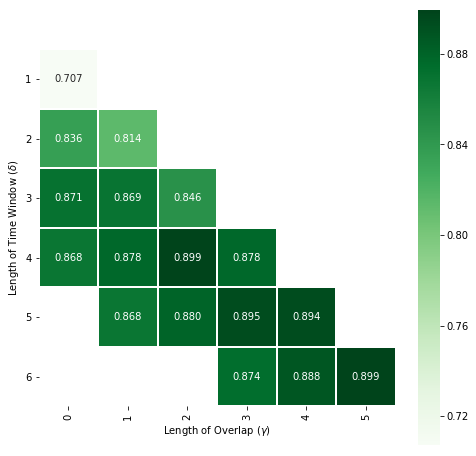

In [5]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


In [6]:
score_authors = get_score_authors(field_name, best_parameters, iN_index_score, __db_name, main_collection_name, experiment_collection_name)


In [7]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to our method")
score_authors.sort_values(by=["param","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 2450 authors, according to our method


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
0,C.Vafa,94,94,54,54,101,101,102.5,102.5,2,1994.500002,4,11,1992,2003,11,1992,2003,113,113
1,J.Polchinski,55,54,34,34,46,46,74.5,74.5,2,1993.500006,4,11,1992,2003,11,1992,2003,55,55
2,A.Sen,84,84,47,47,86,86,102.0,102.0,2,1979.000003,4,11,1992,2003,11,1992,2003,91,91
3,P.K.Townsend,72,72,35,35,67,67,81.0,81.0,2,1963.500000,4,11,1992,2003,11,1992,2003,85,85
4,M.J.Duff,51,51,28,28,41,41,67.0,67.0,2,1953.500002,4,11,1992,2003,11,1992,2003,54,54
5,E.Witten,110,107,63,63,100,100,148.0,148.0,2,1938.500002,4,11,1992,2003,11,1992,2003,110,110
6,C.M.Hull,48,48,21,21,36,36,50.0,50.0,2,1904.000000,4,10,1992,2002,10,1992,2002,58,58
7,J.X.Lu,24,23,13,13,16,16,26.0,26.0,2,1900.000000,4,10,1992,2002,10,1992,2002,24,24
8,N.Seiberg,67,66,49,49,64,64,113.0,113.0,2,1897.999999,4,11,1992,2003,11,1992,2003,67,67
9,R.R.Khuri,34,34,15,15,19,19,38.0,38.0,2,1888.000005,4,10,1992,2002,10,1992,2002,44,44


In [8]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to h-index")
score_authors.sort_values(by=["h_index_local","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 2450 authors, according to h-index


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
5,E.Witten,110,107,63,63,100,100,148.0,148.0,2,1938.500002,4,11,1992,2003,11,1992,2003,110,110
0,C.Vafa,94,94,54,54,101,101,102.5,102.5,2,1994.500002,4,11,1992,2003,11,1992,2003,113,113
8,N.Seiberg,67,66,49,49,64,64,113.0,113.0,2,1897.999999,4,11,1992,2003,11,1992,2003,67,67
2,A.Sen,84,84,47,47,86,86,102.0,102.0,2,1979.000003,4,11,1992,2003,11,1992,2003,91,91
46,A.A.Tseytlin,70,70,42,42,103,103,79.5,79.5,2,1492.000006,4,11,1992,2003,11,1992,2003,126,126
58,A.Strominger,75,75,39,39,68,68,96.0,96.0,2,1407.999995,4,11,1992,2003,11,1992,2003,75,75
90,I.R.Klebanov,76,74,38,38,68,68,81.0,81.0,2,1199.999999,4,11,1992,2003,11,1992,2003,76,76
47,M.R.Douglas,56,56,36,36,52,52,85.0,85.0,2,1489.999998,4,11,1992,2003,11,1992,2003,56,56
10,L.Susskind,66,65,36,36,55,55,92.5,92.5,2,1888.000002,4,11,1992,2003,11,1992,2003,66,66
19,R.Kallosh,55,55,36,36,63,63,54.5,54.5,2,1786.999999,4,11,1992,2003,11,1992,2003,90,90


Spearman correlation with h-index_local: 0.4884099748223652


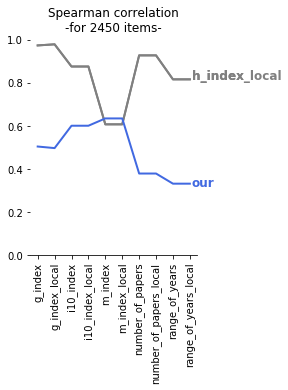

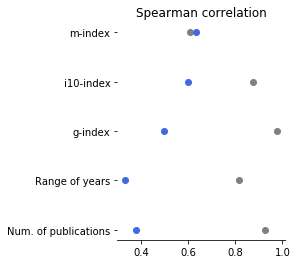

,feature,score,value
0,range_of_years,h_index_local,0.815289
1,range_of_years,h_index,0.815289
2,range_of_years,param,0.330545
3,number_of_papers,h_index_local,0.926726
4,number_of_papers,h_index,0.926726
5,number_of_papers,param,0.377650
6,g_index,h_index_local,0.972959
7,g_index,h_index,0.972959
8,g_index,param,0.503163
9,m_index,h_index_local,0.606274


In [10]:
print("Spearman correlation with h-index_local:",
      score_authors.dropna()["param"].corr(score_authors.dropna()["h_index_local"], method='spearman'))

res = []
for item_1 in ["range_of_years", "number_of_papers", "g_index", "m_index", "i"+str(iN_index_score)+"_index", "range_of_years_local", "number_of_papers_local", "g_index_local", "m_index_local", "i"+str(iN_index_score)+"_index_local"]:#["year_first", "year_first_local", ]
    for item_2 in ["h_index_local", "h_index", "param"]:
        tmp_local = score_authors.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_authors.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_authors(score_authors, iN_index_score)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_authors(score_authors, iN_index_score)))
pd.DataFrame(res)


## Analyze publications

In [11]:
field_name = "_id"

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


'papers-experiment-1992_1994-1995_2003-_id'

### Considering the 3542 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.8725751370666742, 'std': 0.0695724405799697, 'time_window_size': 4, 'overlap': 2}


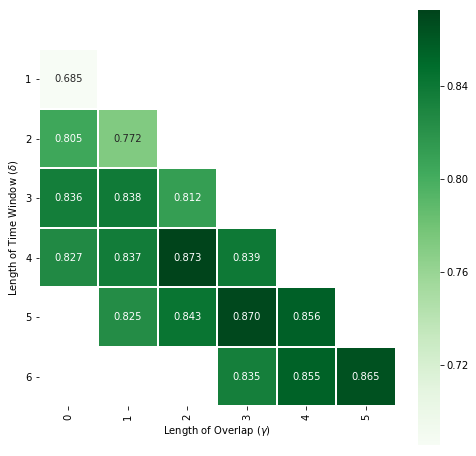

In [13]:
correlations = TW_correlations("original_id", client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


In [16]:
score_papers = get_score_papers("original_id", best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [18]:
print("Top Documents by our method")
score_papers.sort_values(by="param", ascending=False)[["_id", "title", "param", "number_of_citations"]][:40]


Top Documents by our method


,_id,title,param,number_of_citations
0,9408074,A Strong Coupling Test of S-Duality,1919.000003,290
1,9410167,Unity of Superstring Dualities,1908.000000,748
2,9402032,"Dyon - Monopole Bound States, Self-Dual Harmon...",1876.999996,240
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",1869.999998,1299
4,9412184,String Solitons,1867.999998,426
5,9407031,Combinatorics of Boundaries in String Theory,1857.000009,136
6,9409089,The World as a Hologram,1846.000004,427
7,9402002,Strong-Weak Coupling Duality in Four Dimension...,1816.500031,282
8,9307049,Vacuum interpolation in supergravity via super...,1804.000010,172
9,9401139,Target Space Duality in String Theory,1756.500005,421


In [19]:
print("Top Documents by number of citations received")
score_papers.sort_values(by="number_of_citations", ascending=False)[["_id", "title", "number_of_citations", "param"]][:40]


Top Documents by number of citations received


,_id,title,number_of_citations,param
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",1299,1869.999998
13,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",1006,1720.500004
1,9410167,Unity of Superstring Dualities,748,1908.000000
6,9409089,The World as a Hologram,427,1846.000004
4,9412184,String Solitons,426,1867.999998
9,9401139,Target Space Duality in String Theory,421,1756.500005
15,9411149,Electric-Magnetic Duality in Supersymmetric No...,411,1662.000000
26,9204099,The Black Hole in Three Dimensional Space Time,380,1572.499997
18,9301042,Phases of $N=2$ Theories In Two Dimensions,344,1648.000003
42,9411048,Simple Singularities and N=2 Supersymmetric Ya...,314,1389.500004


Spearman correlation with number of references: 0.6039262358616203


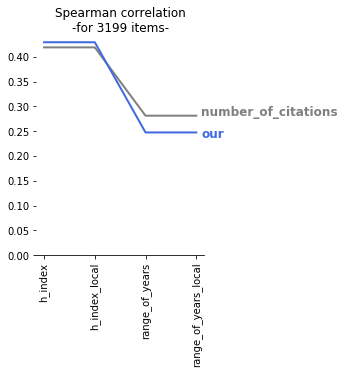

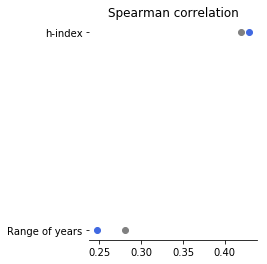

,feature,score,value
0,h_index_local,number_of_citations,0.418857
1,h_index_local,param,0.429200
2,h_index,number_of_citations,0.418857
3,h_index,param,0.429200
4,range_of_years_local,number_of_citations,0.281156
5,range_of_years_local,param,0.247374
6,range_of_years,number_of_citations,0.281156
7,range_of_years,param,0.247374


In [21]:
print("Spearman correlation with number of references:",
      score_papers.dropna()["param"].corr(score_papers.dropna()["number_of_citations"], method='spearman'))
res = []
for item_1 in ["h_index_local", "h_index", "range_of_years_local", "range_of_years"]:#["year_first", "year_first_local", ]
    for item_2 in ["number_of_citations", "param"]:
        tmp_local = score_papers.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_papers.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_papers(score_papers)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_papers(score_papers)))
pd.DataFrame(res)


## Analyze venues

In [23]:
field_name = "venue"
experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name


'papers-experiment-1992_1994-1995_2003-venue'

### Considering the 36 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.895648019458237, 'std': 0.1052713786787089, 'time_window_size': 5, 'overlap': 3}


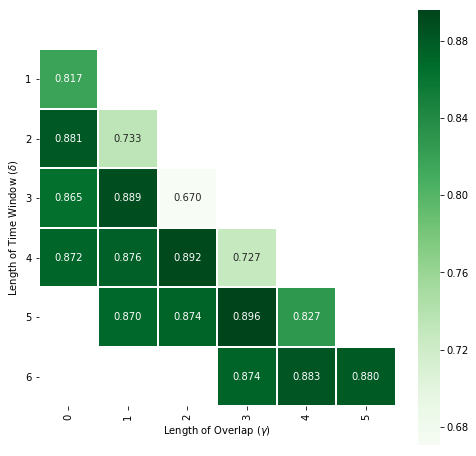

In [24]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


In [25]:
score_venues = get_score_venues(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [26]:
print("Top Venues according to our method")
score_venues.sort_values(by="param", ascending=False)[["venue", "param", "custom_citescore"]][:25]

Top Venues according to our method


,venue,param,custom_citescore
0,J.Math.Phys.,2166.000000,2.494709
1,Phys.Rept.,2146.500000,50.174603
2,Int.J.Mod.Phys.,2139.500000,2.856812
3,Phys.Rev.,2131.000004,8.311272
4,Mod.Phys.Lett.,2118.000000,1.728775
5,Phys.Rev.Lett.,2094.500000,11.155945
6,Commun.Math.Phys.,2080.500000,3.360234
7,Class.Quant.Grav.,2025.000001,5.820988
8,J.Geom.Phys.,2011.500000,4.070175
9,Phys.Lett.,1989.500000,6.807914


In [27]:
print("Top Venues according to our Impact Factor")
score_venues.sort_values(by="custom_citescore", ascending=False)[["venue", "custom_citescore", "param"]][:25]

Top Venues according to our Impact Factor


,venue,custom_citescore,param
1,Phys.Rept.,50.174603,2146.500000
34,Lect.NotesPhys.,27.777778,1.500000
12,Nucl.Phys.Proc.Suppl.,20.584795,1775.999990
23,Fortsch.Phys.,17.711111,138.500000
10,Nucl.Phys.,14.030965,1845.500005
5,Phys.Rev.Lett.,11.155945,2094.500000
44,ChaosSolitonsFractals,8.666667,NaN
3,Phys.Rev.,8.311272,2131.000004
9,Phys.Lett.,6.807914,1989.500000
7,Class.Quant.Grav.,5.820988,2025.000001


Spearman correlation with custom Impact Factor: 0.29961389961389956


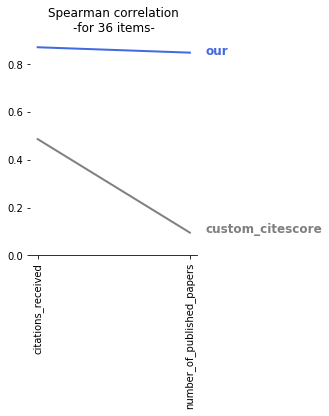

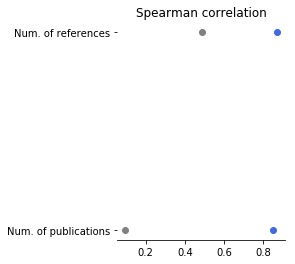

,feature,score,value
0,citations_received,custom_citescore,0.487161
1,citations_received,param,0.871871
2,number_of_published_papers,custom_citescore,0.095441
3,number_of_published_papers,param,0.849305


In [29]:
print("Spearman correlation with custom Impact Factor:",
      score_venues.dropna()["param"].corr(score_venues.dropna()["custom_citescore"], method='spearman'))
res = []
for item_1 in ["citations_received", "number_of_published_papers"]:
    for item_2 in ["custom_citescore", "param"]:
        tmp_local = score_venues.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_venues.dropna()))
plot_correlations(pd.DataFrame(get_correlations_dict_venues(score_venues)).sort_values(by="feature"))

total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict_venues(score_venues)))
pd.DataFrame(res)

## Overview

In [42]:
total_correlations.loc[total_correlations.iloc[:,total_correlations.columns.tolist().index("score")] != "param", "score"] = "baseline"
total_correlations = total_correlations.reset_index(drop=True)
total_correlations


,feature,item,score,value
0,Range of years,Authors,baseline,0.815289
1,Range of years,Authors,param,0.330545
2,Num. of publications,Authors,baseline,0.926726
3,Num. of publications,Authors,param,0.377650
4,g-index,Authors,baseline,0.978068
5,g-index,Authors,param,0.495819
6,m-index,Authors,baseline,0.606274
7,m-index,Authors,param,0.633719
8,i10-index,Authors,baseline,0.874971
9,i10-index,Authors,param,0.599799


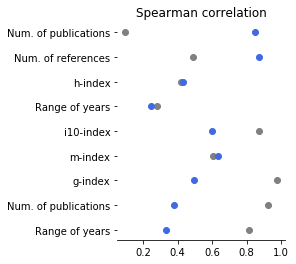

In [43]:
plot_correlations(total_correlations)

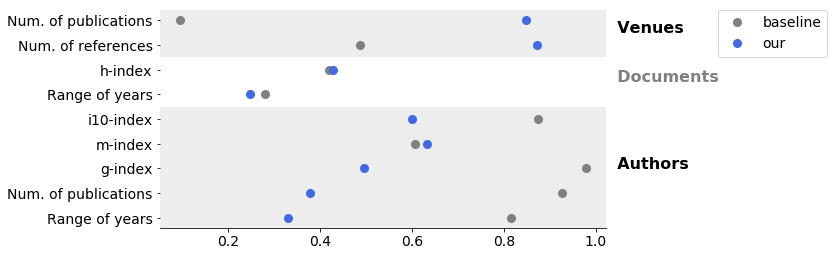

In [46]:
plot_correlations_2(total_correlations, vertical=False, filename=RESULTS_DIR+"/correlations_SNAP_overview.jpg")

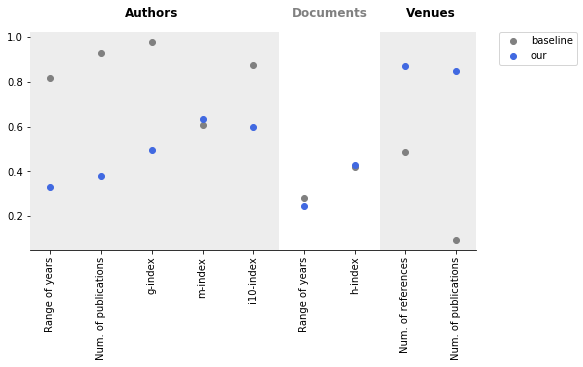

In [33]:
plot_correlations_2(total_correlations, filename=RESULTS_DIR+"/correlations_SNAP_overview-hor.eps")